## Pre processamento

In [2]:
import numpy as np
import pandas as pd# Aprendizado de Comitês
import matplotlib.pyplot as plt
import sklearn

df_diamonds = pd.read_csv('datasets/diamonds.csv')
df_diamonds[df_diamonds.duplicated()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  0 non-null      int64  
 1   carat       0 non-null      float64
 2   cut         0 non-null      object 
 3   color       0 non-null      object 
 4   clarity     0 non-null      object 
 5   depth       0 non-null      float64
 6   table       0 non-null      float64
 7   price       0 non-null      int64  
 8   x           0 non-null      float64
 9   y           0 non-null      float64
 10  z           0 non-null      float64
dtypes: float64(6), int64(2), object(3)
memory usage: 0.0+ bytes


### Remove outliers

In [7]:
df_number_type = df_diamonds.select_dtypes(exclude='O').columns[1:]

def range_for_remove_outliers(attr):
    df_attr = df_diamonds[attr]
    q3 = df_attr.quantile(q=0.75)
    q1 = df_attr.quantile(q=0.25)

    IQR  = q3 - q1
    min_IQR = q1 - 1.5 * IQR
    max_IQR = q3 + 1.5 * IQR
    
    return (min_IQR,max_IQR)

def remove_outlier(df_in, col_name):
    range_iqr = range_for_remove_outliers(col_name)
    df_out = df_in[~((df_in < range_iqr[0]) |(df_in > range_iqr[1])).any(axis=1)]
    return df_out


df_diamonds_ro = remove_outlier(df_diamonds, df_number_type)
 
    
df_diamonds_ro.to_csv('datasets/diamonds_remove_outliers.csv',index=False)

<ipython-input-7-27f9022e3b2a>:16: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_out = df_in[~((df_in < range_iqr[0]) |(df_in > range_iqr[1])).any(axis=1)]
<ipython-input-7-27f9022e3b2a>:16: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_out = df_in[~((df_in < range_iqr[0]) |(df_in > range_iqr[1])).any(axis=1)]


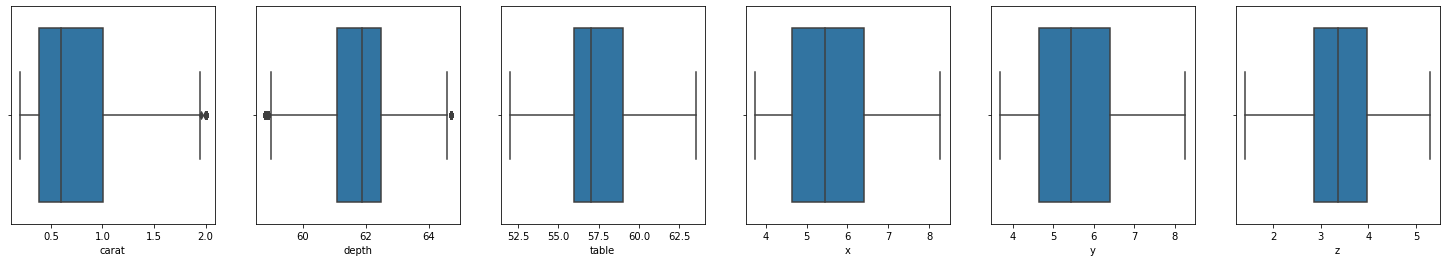

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


df_number_type = df_diamonds_ro.select_dtypes(exclude='O')
df_without_price = df_number_type.drop("price", axis = 'columns')

plt.figure(figsize=(30,4))
for i,feature in enumerate(df_without_price.columns[1:].tolist(),1):
    plt.subplot(1,7,i)
    sns.boxplot(x=df_number_type[feature])

        
plt.show()

## Regressao linear

In [11]:
# Conver to X & y
df_number_type = df_diamonds.select_dtypes(exclude='O')
y=df_number_type['price']
X=df_number_type.drop('price', axis=1)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X , y , test_size=0.2, random_state=1)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix


## Normalização

In [15]:
sc=StandardScaler()
X_train_tx=sc.fit_transform(X_train)
X_test_tx=sc.transform(X_test)

In [16]:
dataset_1=(X_train, X_test, y_train, y_test, 'dataset_1')

In [17]:
# Blank lists for all the details
model_=[]
cv_score_test=[]
cv_score_train=[]
mse_=[]
mae_=[]
rmse_=[]
r2_=[]

In [18]:
def run_model(model, dataset, modelname):
    model.fit(dataset[0], dataset[2])
    accuracies=cross_val_score(estimator=model, X=dataset[0], y=dataset[2], cv=5, verbose=1)
    y_pred=model.predict(dataset[1])
    print('')
    score_1=model.score(dataset[1], dataset[3])
    print(f'#### {modelname} ####')
    print("score :%.4f" %score_1)
    print(accuracies)
    
    
    mse=mean_squared_error(dataset[3], y_pred)
    mae=mean_absolute_error(dataset[3], y_pred)
    rmse=mean_squared_error(dataset[3], y_pred)**0.5
    r2=r2_score(dataset[3], y_pred)
   
    
    print('')
    print('MSE    : %0.2f ' % mse)
    print('MAE    : %0.2f ' % mae)
    print('RMSE   : %0.2f ' % rmse)
    print('R2     : %0.2f ' % r2)
    
    ## appending to the lists
    
    model_.append(modelname)
    cv_score_test.append(score_1)
    cv_score_train.append(np.mean(accuracies))
    mse_.append(mse)
    mae_.append(mae)
    rmse_.append(rmse)
    r2_.append(r2)

In [49]:

model_dict={'LinearRegression': LinearRegression(),
           'RandomForestRegressor': RandomForestRegressor(), 
           'KNeighborsRegressor': KNeighborsRegressor(),
            'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,), batch_size=2, learning_rate_init=0.01, learning_rate="adaptive", max_iter=50, verbose=True)

           }

for models in model_dict:
    run_model(model_dict[models], dataset_1, models)

accuracy_data=pd.DataFrame(zip(model_, cv_score_test, cv_score_train, mse_, mae_, rmse_, r2_), columns=['Model', 'CV Test score', 'CV Train score (mean)', '%%SVGean Squared error', 'Mean Absolute error', 'Root Mean Squared error', 'R2 Score'])

accuracy_data

In [50]:
# run_model(model_dict['LinearRegression'], dataset_1, "LinearRegression")

In [51]:
for models in model_dict:
    run_model(model_dict[models], dataset_1, models)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



#### LinearRegression ####
score :0.8611
[0.8601141  0.85515871 0.86385021 0.85686318 0.85983774]

MSE    : 2158838.67 
MAE    : 905.55 
RMSE   : 1469.30 
R2     : 0.86 

#### LassoRegression ####
score :0.8454
[0.84664714 0.84620141 0.85141459 0.8444506  0.84760685]

MSE    : 2402584.31 
MAE    : 980.92 
RMSE   : 1550.03 
R2     : 0.85 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished



#### AdaBoostRegressor ####
score :0.9875
[0.98918709 0.99029111 0.99075926 0.9913477  0.99080973]

MSE    : 194216.47 
MAE    : 303.83 
RMSE   : 440.70 
R2     : 0.99 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished



#### RidgeRegression ####
score :0.7729
[0.77500592 0.77181094 0.77592831 0.76464178 0.77084216]

MSE    : 3528876.33 
MAE    : 1216.78 
RMSE   : 1878.53 
R2     : 0.77 
      Iter       Train Loss   Remaining Time 
         1    14154820.5543           19.37s
         2    12551947.4294           14.44s
         3    11215196.6146           24.79s
         4    10024374.1165           21.45s
         5     9049180.7672           22.90s
         6     8161238.7715           20.80s
         7     7435634.0832           23.34s
         8     6798288.2557           22.01s
         9     6230404.6579           20.77s
        10     5757126.6662           19.79s
        20     3195232.5282           17.03s
        30     2377074.8209           11.94s
        40     2093347.3915            8.47s
        50     1950787.5021            6.31s
        60     1848688.9737            5.05s
        70     1770057.5748            3.65s
        80     1708542.1965            2.25s
        90     165

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


         6     8246129.4567            2.93s
         7     7504921.2108            3.06s
         8     6853997.5361            3.06s
         9     6283959.3587            3.03s
        10     5800702.9156            2.95s
        20     3207787.4143            2.48s
        30     2385288.5233            2.27s
        40     2098166.5374            2.46s
        50     1955357.7434            2.35s
        60     1852935.4106            2.00s
        70     1774032.6302            1.99s
        80     1712821.2868            1.57s
        90     1663369.4966            0.79s
       100     1623196.1537            0.00s
      Iter       Train Loss   Remaining Time 
         1    14130196.5374            2.96s
         2    12526112.6871           12.84s
         3    11194200.0544           19.96s
         4    10005913.9875           20.67s
         5     9031881.8411           17.36s
         6     8148863.3483           15.46s
         7     7425740.3208           13.87s
         

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished



#### RandomForestRegressor ####
score :0.9999
[0.99985804 0.99982825 0.99989411 0.99981389 0.99989319]

MSE    : 1393.65 
MAE    : 5.45 
RMSE   : 37.33 
R2     : 1.00 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished



#### KNeighborsRegressor ####
score :0.9935
[0.99312903 0.99454886 0.99431777 0.99525537 0.99247625]

MSE    : 101363.53 
MAE    : 34.67 
RMSE   : 318.38 
R2     : 0.99 


In [52]:
accuracy_data=pd.DataFrame(zip(model_, cv_score_test, cv_score_train, mse_, mae_, rmse_, r2_), columns=['Model', 'CV Test score', 'CV Train score (mean)', '%%SVGean Squared error', 'Mean Absolute error', 'Root Mean Squared error', 'R2 Score'])

In [53]:
accuracy_data

,Model,CV Test score,CV Train score (mean),%%SVGean Squared error,Mean Absolute error,Root Mean Squared error,R2 Score
0,LinearRegression,0.861065,0.859165,2.158839e+06,905.550440,1469.298701,0.861065
1,LassoRegression,0.845379,0.847264,2.402584e+06,980.920046,1550.027197,0.845379
2,AdaBoostRegressor,0.987501,0.990479,1.942165e+05,303.829530,440.699976,0.987501
3,RidgeRegression,0.772895,0.771646,3.528876e+06,1216.775628,1878.530365,0.772895
4,GradientBoostingRegressor,0.897679,0.897129,1.589917e+06,770.264346,1260.919306,0.897679
5,RandomForestRegressor,0.999910,0.999857,1.393653e+03,5.450733,37.331659,0.999910
6,KNeighborsRegressor,0.993477,0.993945,1.013635e+05,34.670337,318.376394,0.993477


In [25]:
# tipos_de_avaliacao = ['Com Outiliers sem Normalizacao COSN','Sem Outiliers sem Normalizacao(Unammed)SOSN','Com outiliers e normalizacao CON','Sem Outliers com Normalizacao SON','Com outliers sem unamed com normalizacao', 'Sem outliers sem unamed'] 
# for avaliacao in tipos_de_avaliacao:      

plt.figure(figsize=(20,5))
for i,feature in enumerate(df_diamonds.select_dtypes(include='O').columns.tolist(),1):
    plt.subplot(1,3,i)
    df_diamonds[feature].value_counts(normalize=True).plot.bar()
    plt.title(feature)


,Model,CV Test score,CV Train score (mean),%%SVGean Squared error,Mean Absolute error,Root Mean Squared error,R2 Score
0,LinearRegression,0.861065,0.859165,2.158839e+06,905.550440,1469.298701,0.861065
1,LinearRegression,0.861065,0.859165,2.158839e+06,905.550440,1469.298701,0.861065
2,LassoRegression,0.845379,0.847264,2.402584e+06,980.920046,1550.027197,0.845379
3,AdaBoostRegressor,0.982999,0.989108,2.641776e+05,383.247213,513.982084,0.982999
4,RidgeRegression,0.772895,0.771646,3.528876e+06,1216.775628,1878.530365,0.772895
5,GradientBoostingRegressor,0.897679,0.897129,1.589917e+06,770.264346,1260.919306,0.897679
6,RandomForestRegressor,0.999906,0.999857,1.466881e+03,5.486387,38.299879,0.999906
7,KNeighborsRegressor,0.993477,0.993945,1.013635e+05,34.670337,318.376394,0.993477


['LinearRegression',
 'LinearRegression',
 'LassoRegression',
 'AdaBoostRegressor',
 'RidgeRegression',
 'GradientBoostingRegressor',
 'RandomForestRegressor',
 'KNeighborsRegressor']